<center>
    <b> <font size = 6, color = #e4b414>
    IMDb Top 250 Movies: stars issue

<b/>
<center/>

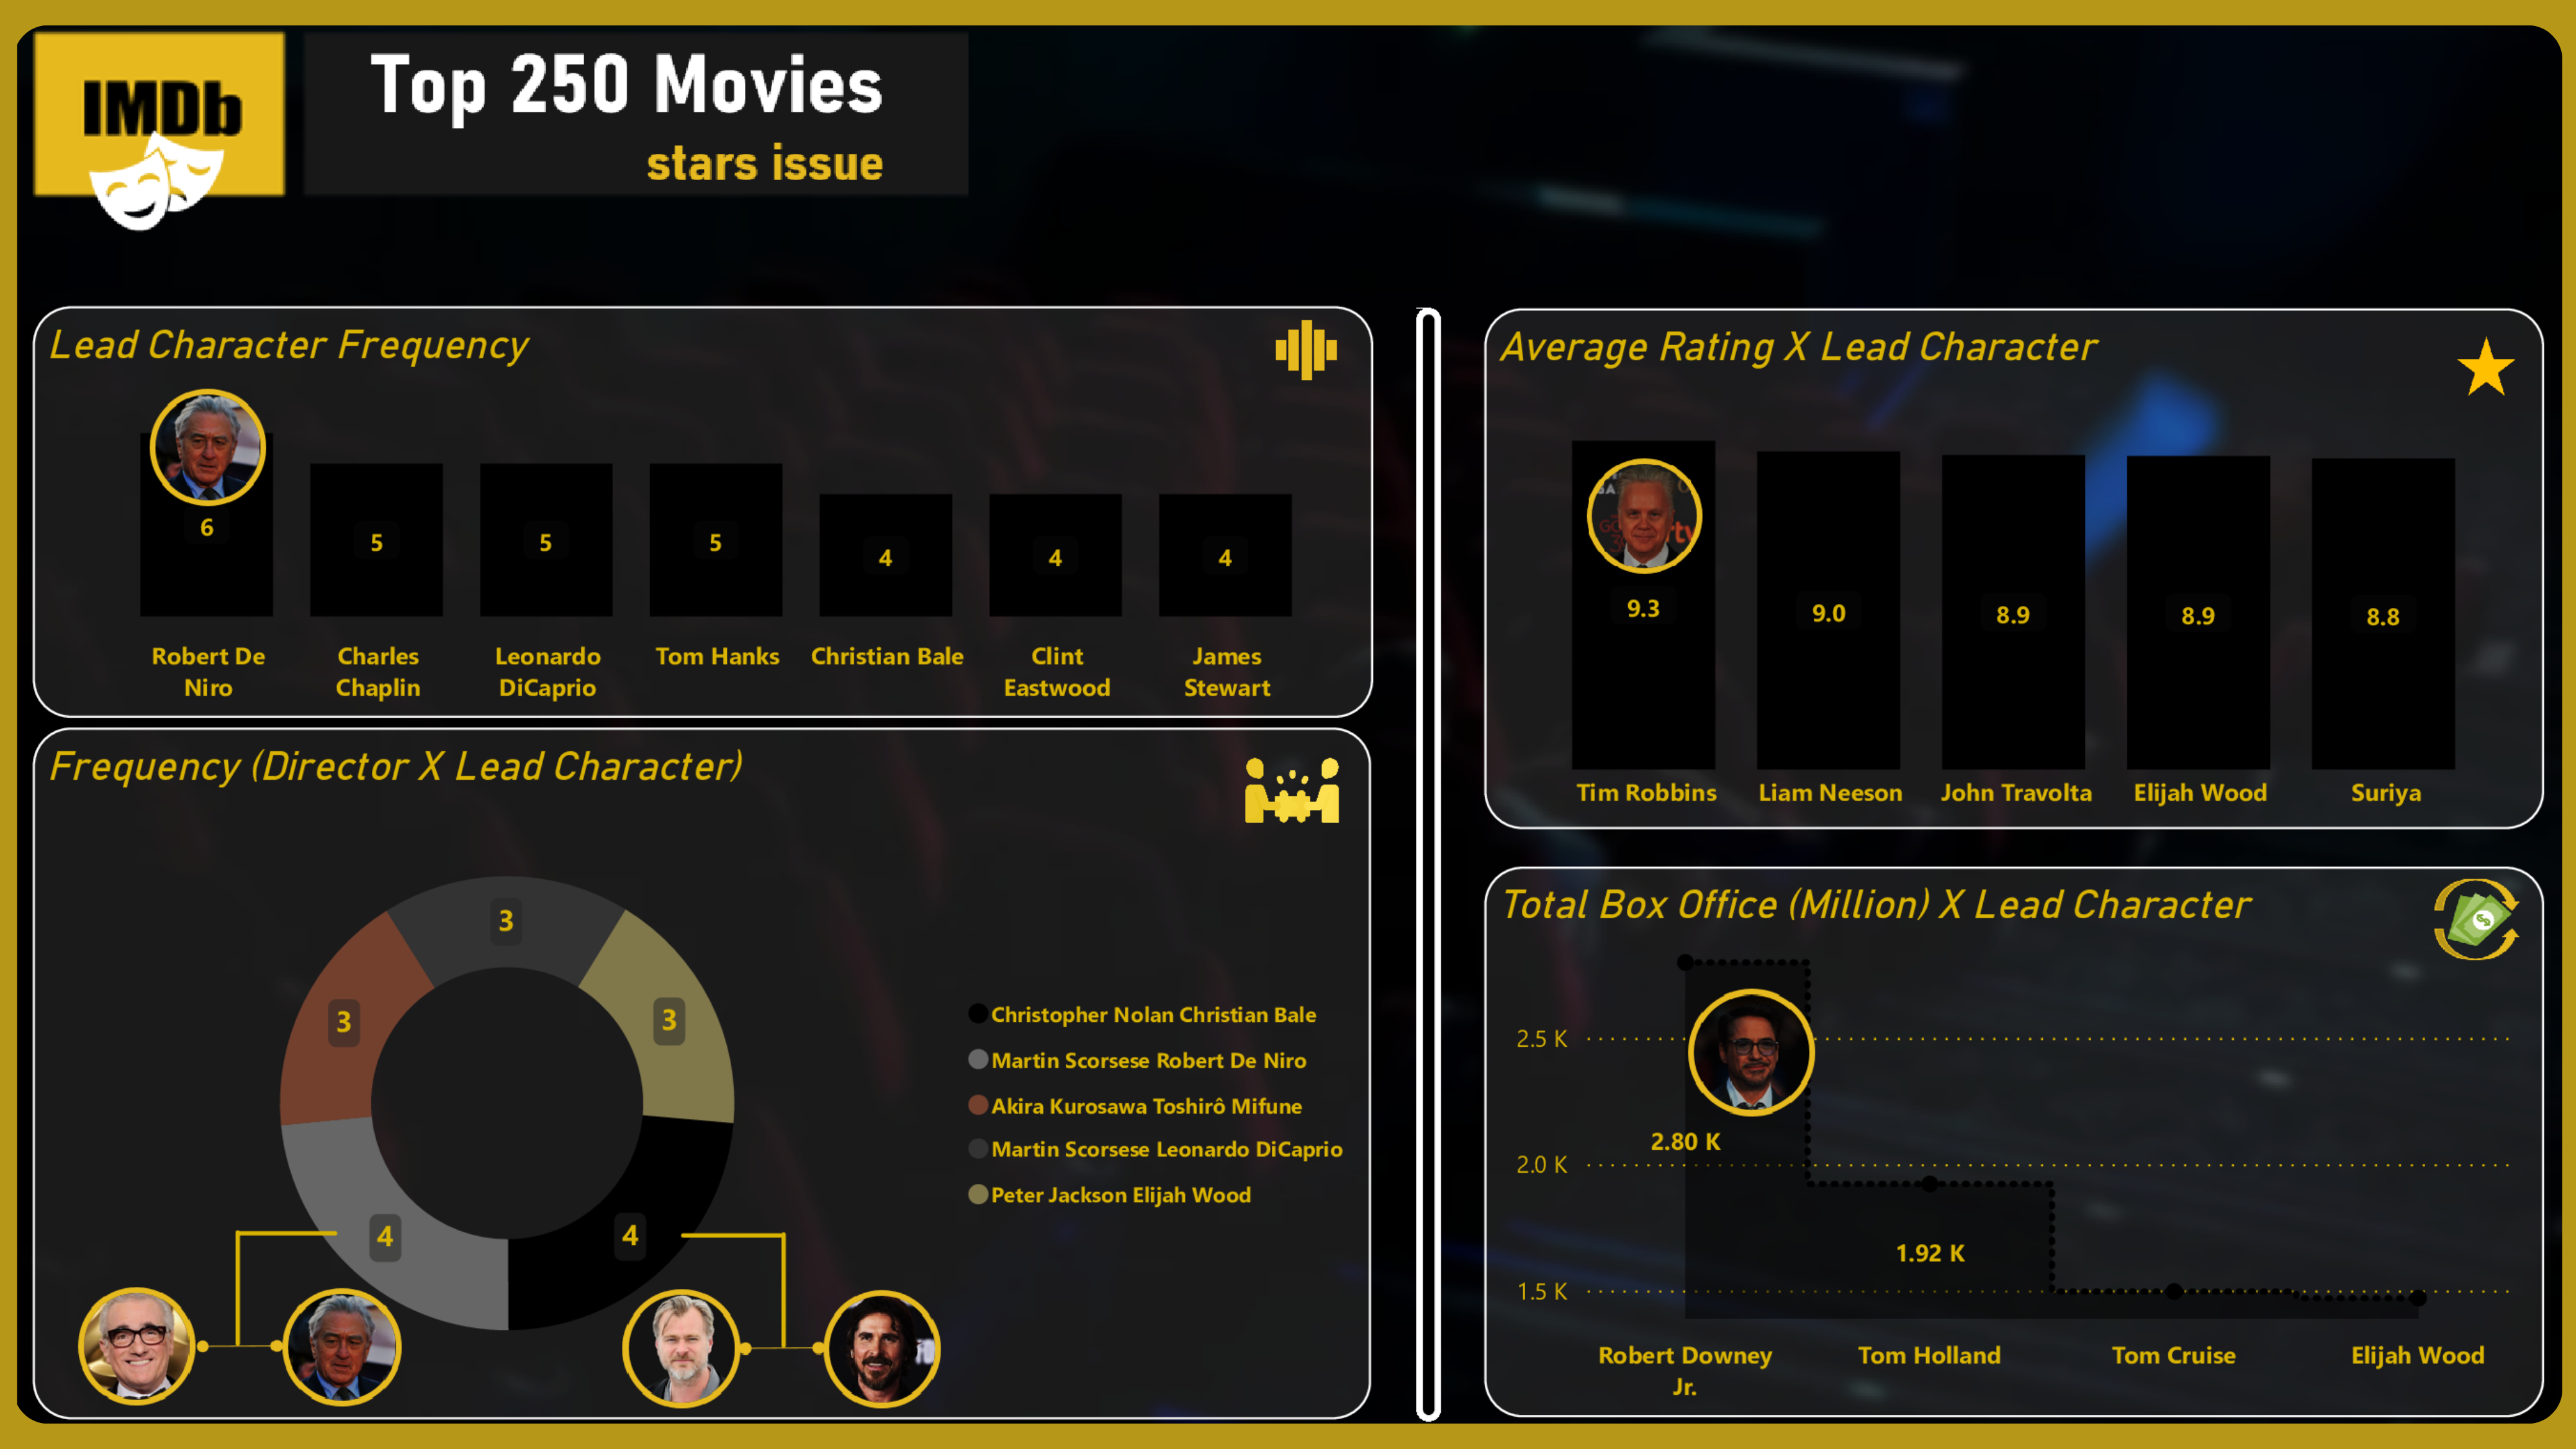

In [1]:
from IPython.display import display, Image
display(Image('IMDbTop250PowerBIReport.png'))

## Summary

This project builds on the IMDbTop100 analysis, expanding it to IMDb's Top 250 movies. It investigates the impact of cast composition on movie ratings, aiming to uncover relationships between cast prominence, actor reappearances, or ensemble diversity and a film’s IMDb score. Starting with web-scraped IMDb data stored in an SQLite database, this analysis leverages correlation techniques and data visualization in pandas to identify patterns in the relationship between cast characteristics and IMDb ratings. Insights from this project may reveal trends such as the influence of recurring actors or star-studded casts on movie success.

## Libraries and Modules

In [2]:
# Webscraping and pattern matching
from seleniumwire import webdriver
from selenium.webdriver.common.by import By
import regex as re
import json
import requests

# Data manipulation 
import pandas as pd
import numpy as np
import sqlite3

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import statsmodels.api as sm

# Omitting warnings
from warnings import filterwarnings as fw
fw('ignore')

## Data Preparation

In [3]:
# Connecting to the SQLite database file created after web scraping and instantiating a cursor object

conn = sqlite3.connect('IMDbTop250Database')
cursor = conn.cursor()

In [4]:
# Fetching the names of all tables in the SQLite database

cursor.execute("SELECT name FROM sqlite_master").fetchall()

[('IMDbTop250',)]

In [5]:
# Closing the cursor object

cursor.close()

In [6]:
# Reading all data from the IMDbTop250 table in the SQLite database into a pandas DataFrame

query = 'SELECT * FROM IMDbTop250'
df = pd.read_sql(query, conn)
df.head()

,title,director,year,rate,lead,supporting_character,secondary_supporting_charactter
0,The Shawshank Redemption,Frank Darabont,1994,9.3,Tim Robbins,Morgan Freeman,Bob Gunton
1,The Godfather,Francis Ford Coppola,1972,9.2,Marlon Brando,Al Pacino,James Caan
2,The Dark Knight,Christopher Nolan,2008,9.0,Christian Bale,Heath Ledger,Aaron Eckhart
3,The Godfather Part II,Francis Ford Coppola,1974,9.0,Al Pacino,Robert De Niro,Robert Duvall
4,12 Angry Men,Sidney Lumet,1957,9.0,Henry Fonda,Lee J. Cobb,Martin Balsam


In [7]:
# Closing the database connection

conn.close()

## Exploratory Data Analysis

In [8]:
# Statistical summary of the cast

df.iloc[:, 5:].describe()

,supporting_character,secondary_supporting_charactter
count,250,250
unique,229,238
top,Harrison Ford,Mark Ruffalo
freq,3,3


In [9]:


release_period_array = df.year.map(lambda cell: 'Before 2000' if cell < 2000 else 'Since 2000').values
df.insert(3, 'release_period', release_period_array)
df.head()

,title,director,year,release_period,rate,lead,supporting_character,secondary_supporting_charactter
0,The Shawshank Redemption,Frank Darabont,1994,Before 2000,9.3,Tim Robbins,Morgan Freeman,Bob Gunton
1,The Godfather,Francis Ford Coppola,1972,Before 2000,9.2,Marlon Brando,Al Pacino,James Caan
2,The Dark Knight,Christopher Nolan,2008,Since 2000,9.0,Christian Bale,Heath Ledger,Aaron Eckhart
3,The Godfather Part II,Francis Ford Coppola,1974,Before 2000,9.0,Al Pacino,Robert De Niro,Robert Duvall
4,12 Angry Men,Sidney Lumet,1957,Before 2000,9.0,Henry Fonda,Lee J. Cobb,Martin Balsam


In [10]:
df.dtypes

title                               object
director                            object
year                                 int64
release_period                      object
rate                               float64
lead                                object
supporting_character                object
secondary_supporting_charactter     object
dtype: object

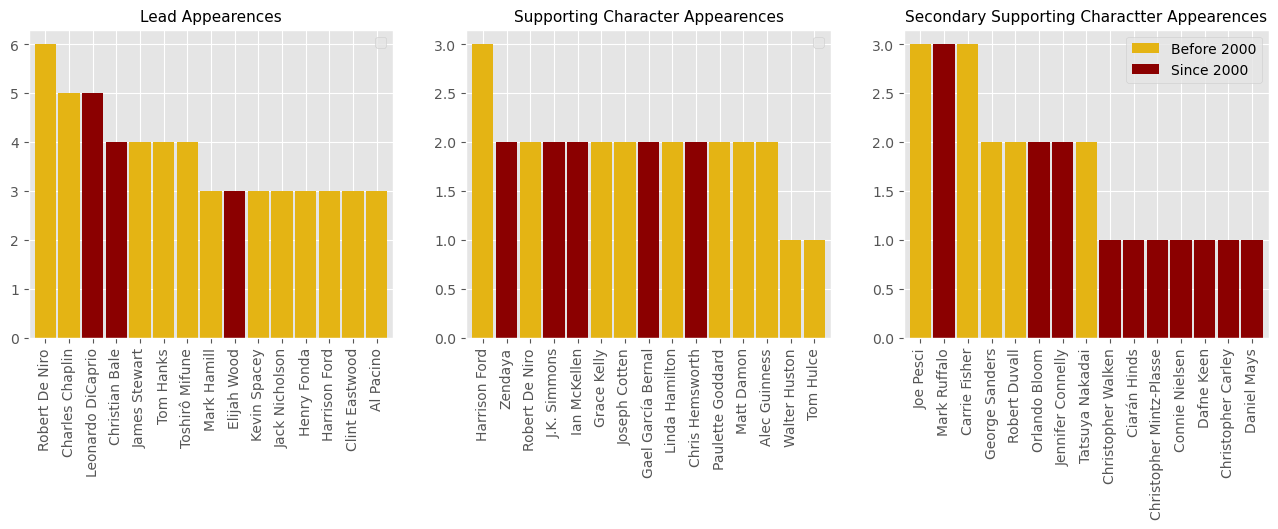

In [11]:
# Cast appeareances by role

fig, axs = plt.subplots(ncols = 3, figsize = (16, 4))

for i, ax in enumerate(axs):
    df.iloc[:, [3,5+i]].value_counts().iloc[:15].unstack(0).plot.bar(stacked = True, 
                                                                     color = ['#e4b414', 'darkred'], width = 0.9, ax = ax)
    ax.set_xlabel('')
    ax.set_title(f"{df.columns[5 + i].title().replace('_', ' ')} Appearences", fontsize = 11)
    ax.legend('')
    axs[2].legend()
plt.show()

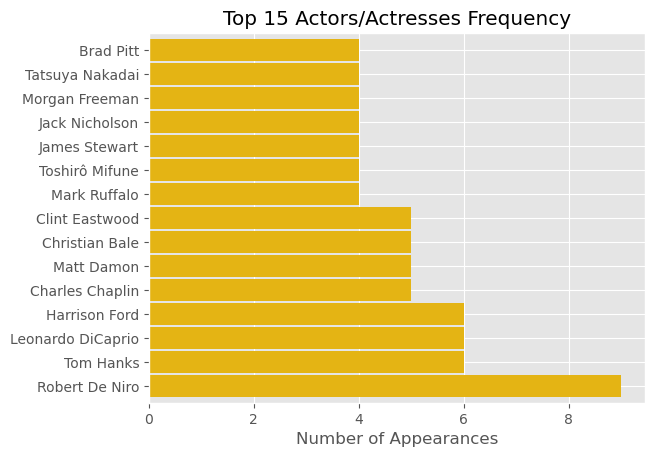

In [12]:
# Counting the appearance frequency of actors/actresses in the IMDb Top 250 movies

pd.Series(df.iloc[:, 5:].values.flatten(), name='star').value_counts()[:15].plot.barh(color = '#e4b414', width = .9)
plt.ylabel('')
plt.title('Top 15 Actors/Actresses Frequency')
plt.xlabel('Number of Appearances')
plt.show()

## Statistical Modeling

In [13]:
# Creating a set for predictors and output variables (and next the predictors are one-hot encoded)

X, y = df.iloc[:, 5:], df.rate
X_ohe = pd.get_dummies(X, drop_first = True).astype(int)
len(X_ohe.columns)

646

In [14]:
# Fitting the statistical model and summary

X_w_const = sm.add_constant(X_ohe)
model = sm.OLS(y, X_w_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     1.259
Date:                Mon, 28 Oct 2024   Prob (F-statistic):              0.547
Time:                        09:22:59   Log-Likelihood:                 641.16
No. Observations:                 250   AIC:                            -786.3
Df Residuals:                       2   BIC:                             87.00
Df Model:                         247                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                           8.1734      0.014    597.607      0.000       8.115       8.232
lead_Adrien Brody                                               0.1089      0.069      1.573      0.256      -0.189       0.407
lead_Ajay Devgn                                                -0.0245      0.069     -0.354      0.757      -0.322       0.273
lead_Al Pacino                                                  0.1897      0.078      2.418      0.137      -0.148       0.527
lead_Albert Brooks                                              0.0089      0.069      0.128      0.910      -0.289       0.307
lead_Aleksey Kravchenko                                         0.0755      0.069      1.091      0.389      -0.222       0.373
lead_Alexandre Rodrigues                                        0.1422      0.069      2.055      0.176      -0.156       0.440
lead_Amy Poehler                                               -0.0245      0.069     -0.354      0.757      -0.322       0.273
lead_Andrew Garfield                                           -0.0245      0.069     -0.354      0.757      -0.322       0.273
lead_Anthony Gonzalez                                           0.1066      0.082      1.297      0.324      -0.247       0.460
lead_Anthony Hopkins                                            0.0133      0.073      0.181      0.873      -0.302       0.329
lead_Anthony Perkins                                            0.1089      0.069      1.573      0.256      -0.189       0.407
lead_Arnold Schwarzenegger                                      0.0706      0.059      1.201      0.353      -0.182       0.324
lead_Audrey Tautou                                              0.0422      0.069      0.610      0.604      -0.256       0.340
lead_Ben Affleck                                               -0.0245      0.069     -0.354      0.757      -0.322       0.273
lead_Ben Burtt                                                  0.0755      0.069      1.091      0.389      -0.222       0.373
lead_Bette Davis                                                0.0191      0.082      0.233      0.838      -0.335       0.373
lead_Bill Murray                                               -0.0578      0.069     -0.835      0.491      -0.356       0.240
lead_Billy Crystal                                             -0.0184      0.082     -0.223      0.844      -0.372       0.335
lead_Brad Garrett                                              -0.0245      0.069     -0.354      0.757      -0.322       0.273
lead_Brad Pitt                                                  0.2133      0.073      2.907      0.101      -0.102       0.529
lead_Brahim

In [15]:
# With 647 attributes (constant term included) and only 250 records, the dataset has a high dimensionality. 
# To identify which attributes are statistically significant, we filter for those with p-values less than or equal to 0.05.

sig_attributes = model.pvalues.to_frame(name='pvalues').query('pvalues <= 0.05')
sig_attributes

,pvalues
const,0.000003
lead_Elijah Wood,0.026708
lead_Tim Robbins,0.032321
supporting_character_Al Pacino,0.040882
supporting_character_Morgan Freeman,0.032321
secondary_supporting_charactter_Bob Gunton,0.032321
secondary_supporting_charactter_James Caan,0.040882


In [16]:
# Fitting the model with significant attributes

X_sig = X_w_const[list(sig_attributes.index)]
model_sig = sm.OLS(y, X_sig).fit()
model_sig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     22.01
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           1.16e-12
Time:                        09:23:00   Log-Likelihood:                 39.236
No. Observations:                 250   AIC:                            -70.47
Df Residuals:                     246   BIC:                            -56.39
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          8.2951      0.013    622.730      0.000       8.269       8.321
lead_Elijah Wood                               0.6049      0.121      4.995      0.000       0.366       0.843
lead_Tim Robbins                               0.3350      0.070      4.810      0.000       0.198       0.472
supporting_character_Al Pacino                 0.4524      0.104      4.331      0.000       0.247       0.658
supporting_character_Morgan Freeman            0.3350      0.070      4.810      0.000       0.198       0.472
secondary_supporting_charactter_Bob Gunton     0.3350      0.070      4.810      0.000       0.198       0.472
secondary_supporting_charactter_James Caan     0.4524      0.104      4.331      0.000       0.247       0.658
==============================================================================
Omnibus:                       48.275   Durbin-Watson:                   0.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.174
Skew:                           1.172   Prob(JB):                     3.51e-16
Kurtosis:                       4.156   Cond. No.                     4.74e+33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.11e-65. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [17]:
# We notice from the above report that there may be multicollinearity among the variables. To further investigate this issue, we will
# check the correlation heatmap of the significant attributes. This will help us identify pairs of variables that are highly correlated 
# and assess their impact on our model's stability.

df_sig = pd.concat([X_sig, y], axis = 1)
df_sig

,const,lead_Elijah Wood,lead_Tim Robbins,supporting_character_Al Pacino,supporting_character_Morgan Freeman,secondary_supporting_charactter_Bob Gunton,secondary_supporting_charactter_James Caan,rate
0,1.0,0,1,0,1,1,0,9.3
1,1.0,0,0,1,0,0,1,9.2
2,1.0,0,0,0,0,0,0,9.0
3,1.0,0,0,0,0,0,0,9.0
4,1.0,0,0,0,0,0,0,9.0
...,...,...,...,...,...,...,...,...
245,1.0,0,0,0,0,0,0,8.1
246,1.0,0,0,0,0,0,0,8.1
247,1.0,0,0,0,0,0,0,8.1
248,1.0,0,0,0,0,0,0,8.1


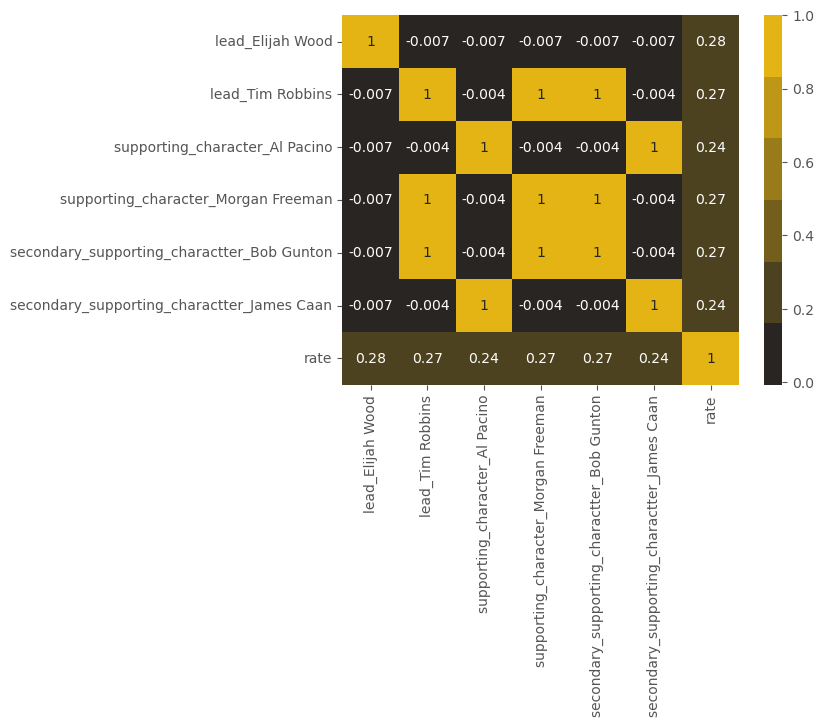

In [18]:
# Correlation heatmap

c_map = sns.dark_palette('#e4b414')
corr_matrix = df_sig.iloc[:, 1:].corr()
sns.heatmap(data = corr_matrix, annot = True, cmap = c_map)
plt.show()

In [19]:
# Investigating multicollinearity

corr_matrix.rate.duplicated().sum()

3

In [20]:
# Removing variables with correlation coefficients similar to those of other variables in the dataset

corr_matrix.drop_duplicates('rate', inplace = True)
corr_matrix

,lead_Elijah Wood,lead_Tim Robbins,supporting_character_Al Pacino,supporting_character_Morgan Freeman,secondary_supporting_charactter_Bob Gunton,secondary_supporting_charactter_James Caan,rate
lead_Elijah Wood,1.000000,-0.006984,-0.006984,-0.006984,-0.006984,-0.006984,0.279141
lead_Tim Robbins,-0.006984,1.000000,-0.004016,1.000000,1.000000,-0.004016,0.269337
supporting_character_Al Pacino,-0.006984,-0.004016,1.000000,-0.004016,-0.004016,1.000000,0.242131
rate,0.279141,0.269337,0.242131,0.269337,0.269337,0.242131,1.000000


In [21]:
# Removing variables with correlation coefficients similar to those of other variables in the dataset

unc_cols = list(corr_matrix.index)[:-1]
X_unc = X_w_const[unc_cols]
X_unc

,lead_Elijah Wood,lead_Tim Robbins,supporting_character_Al Pacino
0,0,1,0
1,0,0,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
245,0,0,0
246,0,0,0
247,0,0,0
248,0,0,0


In [22]:
# Fitting the model with significant and uncorrelated attributes

X_unc_const = sm.add_constant(X_unc)
model_sig_unc = sm.OLS(y, X_unc_const).fit()
model_sig_unc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     22.01
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           1.16e-12
Time:                        09:23:01   Log-Likelihood:                 39.236
No. Observations:                 250   AIC:                            -70.47
Df Residuals:                     246   BIC:                            -56.39
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              8.2951      0.013    622.730      0.000       8.269       8.321
lead_Elijah Wood                   0.6049      0.121      4.995      0.000       0.366       0.843
lead_Tim Robbins                   1.0049      0.209      4.810      0.000       0.593       1.416
supporting_character_Al Pacino     0.9049      0.209      4.331      0.000       0.493       1.316
==============================================================================
Omnibus:                       48.275   Durbin-Watson:                   0.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.174
Skew:                           1.172   Prob(JB):                     3.51e-16
Kurtosis:                       4.156   Cond. No.                         15.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

                 ________  ________   _______   ______
                 /_  __/ / / / ____/  / ____/ | / / __ \
                  / / / /_/ / __/    / __/ /  |/ / / / /
                 / / / __  / /___   / /___/ /|  / /_/ /
                /_/ /_/ /_/_____/  /_____/_/ |_/_____/  
